In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load data
sensor_df10m_final = pd.read_csv("/content/sensor_df10m_final.csv")

In [4]:
sensor_df10m_final.set_index('Server_Date', inplace=True)

In [5]:
# Sort index (important for time-series modeling)
sensor_df10m_final = sensor_df10m_final.sort_index()

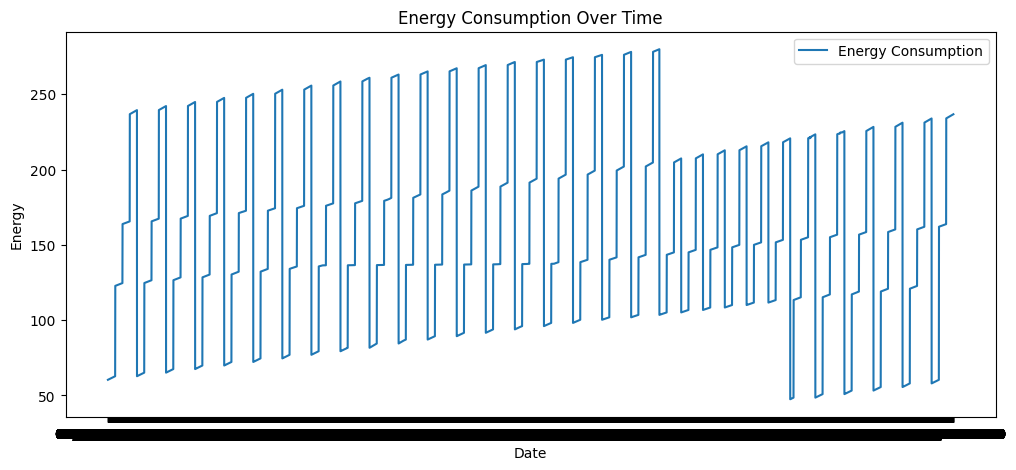

In [6]:
# Visualize the Energy column
plt.figure(figsize=(12, 5))
plt.plot(sensor_df10m_final['Energy'], label='Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()

# Check for NULL values in the dataframe

In [7]:
sensor_df10m_final.isnull().sum()

,0
Voltage,0
Power,0
Frequency,0
Energy,0
Power_Factor,0


# Check Stationarity (ADF Test)

In [8]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Data is not stationary. Differencing needed.")
    else:
        print("Data is stationary.")

In [9]:
adf_test(sensor_df10m_final['Energy'])

ADF Statistic: -8.460648378187498
p-value: 1.5706983532911577e-13
Data is stationary.


# Decomposition of Time Series

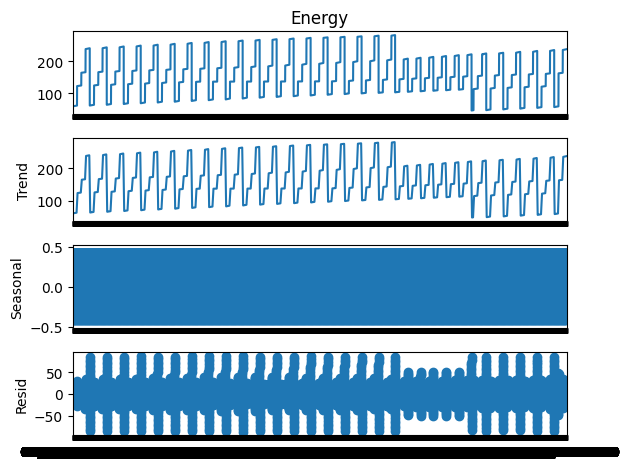

In [10]:
result = seasonal_decompose(sensor_df10m_final['Energy'], model='additive', period=30)
result.plot()
plt.show()

# Plot ACF & PACF for AR and MA terms

These plots help us understand the autocorrelation structure of your time series:

**ACF (Autocorrelation Function):**
- The ACF plot shows the correlation between the time series and its lagged values.
- It helps identify the presence of a Moving Average (MA) component in your model.
- If we see significant spikes at certain lags that then gradually decay, it suggests that past error terms (noise) have an influence, which is characteristic of an MA process.

**PACF (Partial Autocorrelation Function):**
- The PACF plot displays the correlation between the time series and its lags after removing the effects of shorter lags.
- It helps in identifying the Autoregressive (AR) component.
- If you see significant spikes at early lags in the PACF plot (and then a sharp cutoff), it indicates that past values of the series (its own lagged values) are influencing the current value, which is characteristic of an AR process.

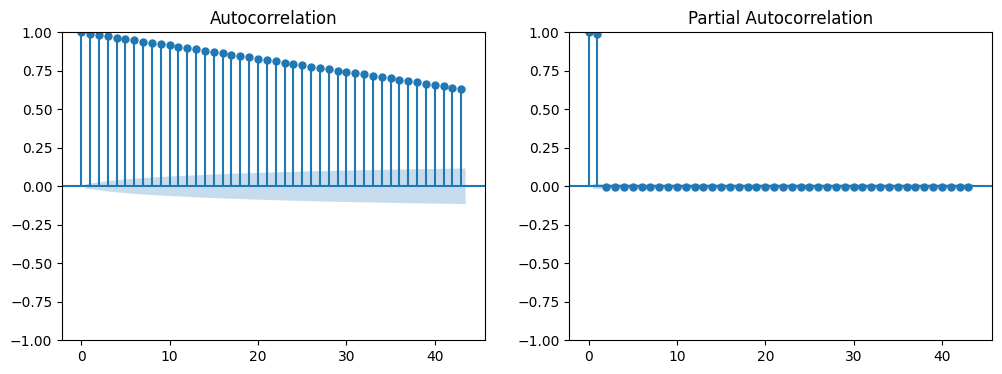

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(sensor_df10m_final['Energy'], ax=axes[0])  # MA(q) term
plot_pacf(sensor_df10m_final['Energy'], ax=axes[1]) # AR(p) term
plt.show()

# Train ARIMA Model

In [14]:
# Extract the energy column
energy_series = sensor_df10m_final["Energy"]

# Define ARIMA order (p, d, q) -> You can tune this
p, d, q = 0, 1, 0

# Store predictions
# First 5 values will not have predictions
predictions = [np.nan] * 5

# Rolling forecast
for i in range(5, len(energy_series)):
    # Train ARIMA on the last 5 records
    train_data = energy_series.iloc[i-5:i]
    model = ARIMA(train_data, order=(p, d, q))
    fitted_model = model.fit()

    # Predict the next value
    pred = fitted_model.forecast(steps=1).values[0]
    predictions.append(pred)

# Add predictions to the dataframe
sensor_df10m_final["Predicted_Energy"] = predictions

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3

# Print the predicted values

In [15]:
# Reset index before printing a sample of actual & predicted values
sensor_df10m_final = sensor_df10m_final.reset_index()

In [19]:
sensor_df10m_final[["Server_Date", "Energy", "Predicted_Energy"]].head(20)

,Server_Date,Energy,Predicted_Energy
0,01/06/21 00:00,60.396625,NaN
1,01/06/21 00:10,60.414208,NaN
2,01/06/21 00:20,60.429668,NaN
3,01/06/21 00:30,60.445304,NaN
4,01/06/21 00:40,60.463541,NaN
5,01/06/21 00:50,60.478465,60.463541
6,01/06/21 01:00,60.494714,60.478465
7,01/06/21 01:10,60.511688,60.494714
8,01/06/21 01:20,60.527214,60.511688
9,01/06/21 01:30,60.544070,60.527214


In [18]:
# Print a sample of actual vs. predicted values
sensor_df10m_final[["Server_Date", "Energy", "Predicted_Energy"]].tail(20)

,Server_Date,Energy,Predicted_Energy
16734,31/08/21 20:40,236.345466,236.326042
16735,31/08/21 20:50,236.364891,236.345466
16736,31/08/21 21:00,236.384315,236.364891
16737,31/08/21 21:10,236.403739,236.384315
16738,31/08/21 21:20,236.423163,236.403739
16739,31/08/21 21:30,236.442587,236.423163
16740,31/08/21 21:40,236.462011,236.442587
16741,31/08/21 21:50,236.481435,236.462011
16742,31/08/21 22:00,236.500859,236.481435
16743,31/08/21 22:10,236.520283,236.500859


# Plot the Predictions

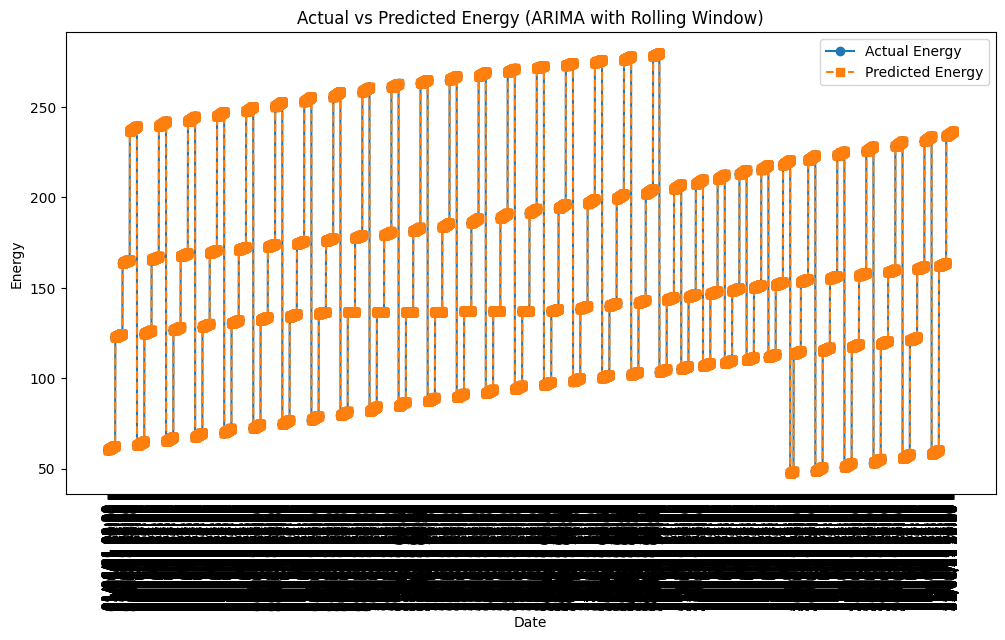

In [20]:
# Plot Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(sensor_df10m_final["Server_Date"], sensor_df10m_final["Energy"], label="Actual Energy", marker="o")
plt.plot(sensor_df10m_final["Server_Date"], sensor_df10m_final["Predicted_Energy"], label="Predicted Energy", marker="s", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Energy")
plt.title("Actual vs Predicted Energy (ARIMA with Rolling Window)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Evaluate MAE and RMSE of the trained ARIMA Model

In [21]:
# Calculate MAE, RMSE
valid_idx = ~sensor_df10m_final["Predicted_Energy"].isna()  # Ignore first 5 NaNs
mae = mean_absolute_error(sensor_df10m_final.loc[valid_idx, "Energy"], sensor_df10m_final.loc[valid_idx, "Predicted_Energy"])
rmse = np.sqrt(mean_squared_error(sensor_df10m_final.loc[valid_idx, "Energy"], sensor_df10m_final.loc[valid_idx, "Predicted_Energy"]))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.6011079817636874
RMSE: 8.231463384870427


In [16]:
auto_arima_model.order

(0, 1, 0)

In [ ]:
# Define ARIMA model
p, d, q = auto_arima_model.order
arima_model = ARIMA(sensor_df10m_final['Energy'], order=(p, d, q))
arima_result = arima_model.fit()

In [ ]:
# Summary
arima_result.summary()

# Forecast Future Energy Values

In [29]:
# Forecast next 10 timestamps
forecast_steps = 10
forecast = arima_result.forecast(steps=forecast_steps)
forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
16754,236.714523
16755,236.714523
16756,236.714523
16757,236.714523
16758,236.714523
16759,236.714523
16760,236.714523
16761,236.714523
16762,236.714523
16763,236.714523


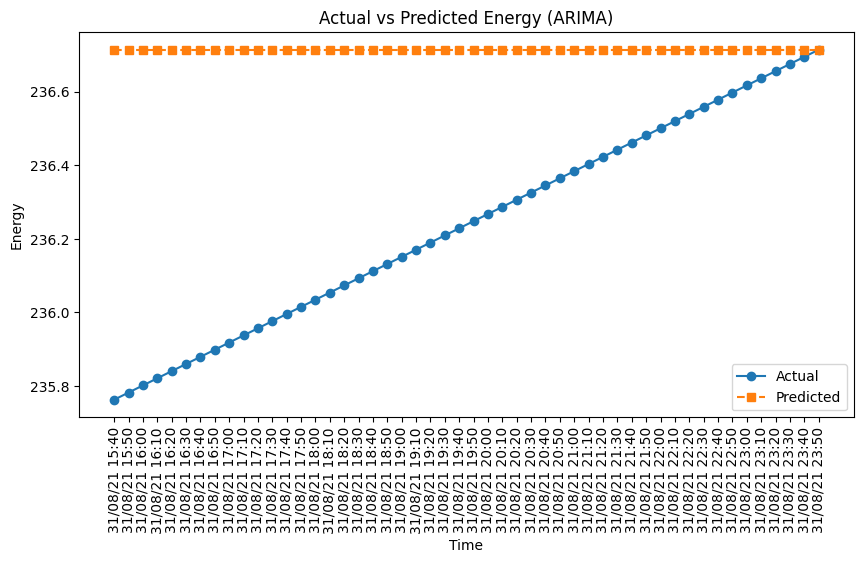

In [26]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', marker='s', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Actual vs Predicted Energy (ARIMA)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Performance Evaluation

In [48]:
# Train-test split (80-20)
train_size = int(0.8 * len(sensor_df10m_final))
train, test = sensor_df10m_final.iloc[:train_size], sensor_df10m_final.iloc[train_size:]

# Fit ARIMA on training data
arima_train_model = ARIMA(train['Energy'], order=(p, d, q)).fit()

# Predict on test data
test_pred = arima_train_model.forecast(steps=len(test))

# Compute error metrics
mae = mean_absolute_error(test['Energy'], test_pred)
rmse = np.sqrt(mean_squared_error(test['Energy'], test_pred))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE: 7.4325
RMSE: 8.1581
